In [ ]:
from omegaconf import OmegaConf

conf = OmegaConf.load('coli.yaml')
conf.log_dir = conf.log_dir + f'd{conf.model.feature_dim}/'

# SVM + original data

In [ ]:
import numpy as np

from dataset import Dataset_coli
original_traj = Dataset_coli(conf, test=True, fitness=True).test_data # (N, T, L)
N, T, L = original_traj.shape
original_traj = Dataset_coli(conf, test=True, fitness=True).scaler.inverse_transform(original_traj.reshape(-1, L)).reshape(N, T, L)

X = original_traj[:,:,1:].reshape(-1, original_traj.shape[2]-1)
y = original_traj[:,:,0].reshape(-1)

np.random.seed(0)
ratio = 0.25
idx = np.random.permutation(X.shape[0])
X_train = X[idx[:int(ratio*X.shape[0])]]
y_train = y[idx[:int(ratio*X.shape[0])]]
X_test = X[idx[int(ratio*X.shape[0]):]]
y_test = y[idx[int(ratio*X.shape[0]):]]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((114, 7), (114,), (345, 7), (345,))

In [ ]:
from sklearn.svm import SVR

predictor = SVR(kernel='rbf')

predictor.fit(X_train, y_train)

ml_predictions = predictor.predict(X_test)
print(ml_predictions.shape)

(345,)


In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, ml_predictions)
nmse = np.mean((y_test - ml_predictions)**2) / np.mean(y_test**2)

r2, nmse

(0.46010837519309844, 0.538173403193898)

# SVR + Neural embedding

In [ ]:
import numpy as np

from dataset import Dataset_coli
original_traj = Dataset_coli(conf, test=True, fitness=True).test_data # (N, T, L)

X = original_traj[:,:,1:].reshape(-1, original_traj.shape[2]-1)
y = original_traj[:,:,0].reshape(-1)

np.random.seed(0)
ratio = 0.25
idx = np.random.permutation(X.shape[0])
X_train = X[idx[:int(ratio*X.shape[0])]]
y_train = y[idx[:int(ratio*X.shape[0])]]
X_test = X[idx[int(ratio*X.shape[0]):]]
y_test = y[idx[int(ratio*X.shape[0]):]]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((114, 7), (114,), (345, 7), (345,))

In [ ]:
import torch
import warnings; warnings.filterwarnings("ignore")

from model import GenotypeEncoder

L = conf.coli.loci
feature_dim = conf.model.feature_dim
encoder = GenotypeEncoder(L, feature_dim).to(conf.device)
encoder.load_state_dict(torch.load(conf.log_dir + f'checkpoints/distill_1000.pth', map_location=conf.device))

encoder.eval()
X_train = torch.tensor(X_train, dtype=torch.float32).to(conf.device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(conf.device)
with torch.no_grad():
    z_train = encoder(X_train.unsqueeze(0))[0]
    z_test = encoder(X_test.unsqueeze(0))[0]
z_train = z_train.cpu().numpy()
z_test = z_test.cpu().numpy()

z_train.shape, z_test.shape

((114, 64), (345, 64))

In [ ]:
# SVR
predictor = SVR(kernel='rbf')

predictor.fit(z_train, y_train)

ml_predictions_z = predictor.predict(z_test)
print(ml_predictions_z.shape)

(345,)


In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, ml_predictions_z)
nmse = np.mean((y_test - ml_predictions_z)**2) / np.mean(y_test**2)

r2, nmse

(0.8311261807860357, 0.026180090243784638)

<Figure size 600x400 with 0 Axes>

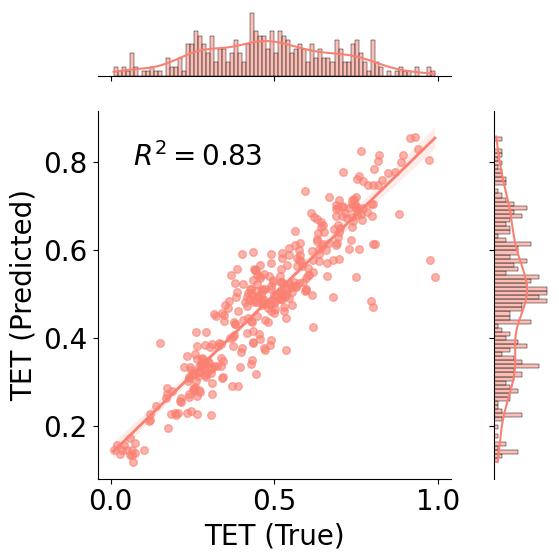

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'xtick.labelsize': 20})
plt.rcParams.update({'ytick.labelsize': 20})
plt.rcParams.update({'legend.fontsize': 20})

plt.figure(figsize=(6, 4))
g = sns.jointplot(x=y_test, y=ml_predictions_z, kind='reg', marginal_kws=dict(bins=80, fill=True), color='salmon', scatter_kws={'s': 40, 'alpha': 0.6}, line_kws={'linewidth': 2}, ratio=4)
plt.text(0.1, 0.85, rf'$R^2={r2:.2f}$', transform=plt.gca().transAxes)
plt.xlabel('TET (True)')
plt.ylabel('TET (Predicted)')
# plt.xlim(-0.25, 1.15)
# plt.ylim(-0.25, 1.15)
# plt.xticks(np.arange(-0.1, 1.1, 0.2))
# plt.yticks(np.arange(-0.1, 1.1, 0.2))
plt.tight_layout()
plt.savefig('figs/fig6/fitness_predict.pdf', dpi=300)

# Data ratio

In [ ]:
import torch
import warnings; warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from omegaconf import OmegaConf
from sklearn.svm import SVR
from sklearn.metrics import r2_score

from dataset import Dataset_coli
from model import GenotypeEncoder


conf = OmegaConf.load('coli.yaml')
conf.log_dir = conf.log_dir + f'd{conf.model.feature_dim}/'

df = pd.DataFrame(columns=['ratio', 'Embed', 'r2', 'nmse'])
ratio_list = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
for ratio in ratio_list:
    for seed in range(10):
        np.random.seed(seed)

        original_traj = Dataset_coli(conf, test=True, fitness=True).test_data # (N, T, L)
        N, T, L = original_traj.shape
        original_traj = Dataset_coli(conf, test=True, fitness=True).scaler.inverse_transform(original_traj.reshape(-1, L)).reshape(N, T, L)

        X = original_traj[:,:,1:].reshape(-1, original_traj.shape[2]-1)
        y = original_traj[:,:,0].reshape(-1)

        idx = np.random.permutation(X.shape[0])
        X_train = X[idx[:int(ratio*X.shape[0])]]
        y_train = y[idx[:int(ratio*X.shape[0])]]
        X_test = X[idx[int(ratio*X.shape[0]):]]
        y_test = y[idx[int(ratio*X.shape[0]):]]

        predictor = SVR(kernel='rbf')

        predictor.fit(X_train, y_train)

        ml_predictions = predictor.predict(X_test)

        r2_ = r2_score(y_test, ml_predictions)
        nmse_ = np.mean((y_test - ml_predictions)**2) / np.mean(y_test**2)




        original_traj = Dataset_coli(conf, test=True, fitness=True).test_data # (N, T, L)

        X = original_traj[:,:,1:].reshape(-1, original_traj.shape[2]-1)
        y = original_traj[:,:,0].reshape(-1)

        idx = np.random.permutation(X.shape[0])
        X_train = X[idx[:int(ratio*X.shape[0])]]
        y_train = y[idx[:int(ratio*X.shape[0])]]
        X_test = X[idx[int(ratio*X.shape[0]):]]
        y_test = y[idx[int(ratio*X.shape[0]):]]
        
        L = conf.coli.loci
        feature_dim = conf.model.feature_dim
        encoder = GenotypeEncoder(L, feature_dim).to(conf.device)
        encoder.load_state_dict(torch.load(conf.log_dir + f'checkpoints/distill_1000.pth', map_location=conf.device))

        encoder.eval()
        X_train = torch.tensor(X_train, dtype=torch.float32).to(conf.device)
        X_test = torch.tensor(X_test, dtype=torch.float32).to(conf.device)
        with torch.no_grad():
            z_train = encoder(X_train.unsqueeze(0))[0]
            z_test = encoder(X_test.unsqueeze(0))[0]
        z_train = z_train.cpu().numpy()
        z_test = z_test.cpu().numpy()

        # SVR
        predictor = SVR(kernel='rbf')

        predictor.fit(z_train, y_train)

        ml_predictions_z = predictor.predict(z_test)

        from sklearn.metrics import r2_score
        r2 = r2_score(y_test, ml_predictions_z)
        nmse = np.mean((y_test - ml_predictions_z)**2) / np.mean(y_test**2)
        
        df = df._append({'ratio': ratio, 'Embed': 'Yes', 'r2': r2, 'nmse': nmse}, ignore_index=True)
        df = df._append({'ratio': ratio, 'Embed': 'No', 'r2': r2_, 'nmse': nmse_}, ignore_index=True)

df

,ratio,Embed,r2,nmse
0,0.1,Yes,0.635655,0.056598
1,0.1,No,0.238383,0.756278
2,0.1,Yes,0.654688,0.054393
3,0.1,No,0.284017,0.712546
4,0.1,Yes,0.707829,0.045503
...,...,...,...,...
175,0.5,No,0.494317,0.504437
176,0.5,Yes,0.828105,0.029059
177,0.5,No,0.523787,0.476149
178,0.5,Yes,0.820409,0.029775


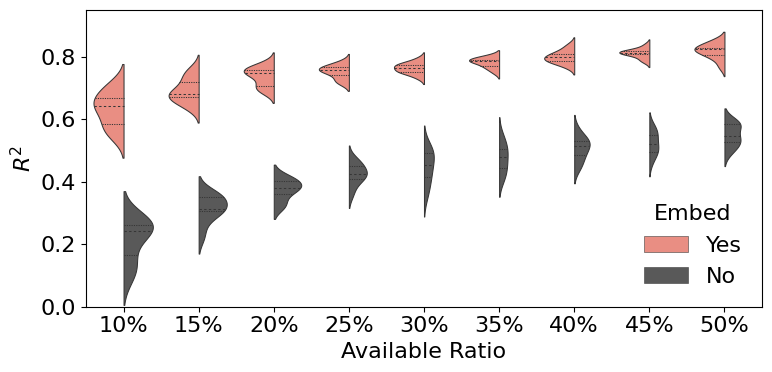

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'xtick.labelsize': 16})
plt.rcParams.update({'ytick.labelsize': 16})
plt.rcParams.update({'legend.fontsize': 16})

plt.figure(figsize=(8, 4))
sns.violinplot(data=df, x='ratio', y='r2', hue='Embed', palette={"Yes": "salmon", "No": ".35"}, split=True, inner="quart", linewidth=.75)
plt.xlabel('Available Ratio')
plt.ylabel(r'$R^2$')
plt.ylim(0, 0.95)
plt.yticks([0., 0.2, 0.4, 0.6, 0.8])
plt.xticks(range(len(ratio_list)), [f'{r*100:.0f}%' for r in ratio_list])
plt.legend(frameon=False, title='Embed')
plt.tight_layout()
plt.savefig('figs/fig6/fitness_ratio_r2.pdf', dpi=300)